<a href="https://colab.research.google.com/github/TannerWaltz/XternDataScience/blob/main/XternDataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FoodieX Data Insights


---

## The Dataset
The dataset consists information about 2019 restaurants in a town in southern Indiana. This information includes Resturant ID, Latitude, Longitude, Cuisines, Average Cost, Minimum Order, Rating, Votes, Reviews and Cook Time.

The company FoodieX wants insights from this dataset to help it become the best delivery service in town.

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filename = "2020-XTern-DS.csv"
data = pd.read_csv(filename)

data

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",$20.00,$50.00,3.5,12,4,30 minutes
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",$10.00,$50.00,3.5,11,4,30 minutes
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",$15.00,$50.00,3.6,99,30,65 minutes
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",$25.00,$99.00,3.7,176,95,30 minutes
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",$20.00,$99.00,3.2,521,235,65 minutes
...,...,...,...,...,...,...,...,...,...,...
2014,ID_4366,39.624978,-85.189212,"North Indian, Pizza, Burger, Continental",$40.00,$0.00,-,-,-,30 minutes
2015,ID_319,39.133719,-85.503020,"Awadhi, Bihari",$40.00,$99.00,4.1,118,91,30 minutes
2016,ID_3104,39.662987,-85.950894,"Fast Food, Beverages",$10.00,$50.00,NEW,-,-,30 minutes
2017,ID_4396,39.301765,-85.662768,"Kebab, Fast Food",$10.00,$50.00,-,-,-,30 minutes


## Cleaning the Data


---

Before any analysis can be performed, the dataset first needs to be cleaned in order to be useable for analysis.

First, two incorrectly formatted dollar amounts in the Average_Cost column are changed to match the rest of the column.

In [172]:
data = data.replace(["1,00", "1,20"], ["$1.00", "$1.20"])

Next, the dollar sign ($) in each Average_Cost and Minumum_Order entry is removed, and the datetype of both columns is changed to float for use in analysis.

In [173]:
for col in ['Average_Cost', 'Minimum_Order']:
    for i in range(len(data[col])):
        data.loc[i, col] = data.loc[i, col][1:]
    data[col] = data[col].astype(float)

Next, the word "minutes" is removed from each entry in the Cook_Time column, and the datatype is changed to integers for use in analysis.

In [174]:
for col in ['Cook_Time']:
    for i in range(len(data[col])):
        data.loc[i, col] = data.loc[i, col][:-8]
    data[col] = data[col].astype(int)

In the original dataset, a restuarant can serve more than one cuisine. However, this information is all stored in a single column. For use in analysis, indicator variables will be created and added to the dataset for each restaurant, indicating if the restaurant serves a particular cuisine or not. A list storing all of the cuisine columns names is also stored for use later.

In [175]:
tempCuisines = data.Cuisines.str.split(", ", expand=True).stack()
data = pd.concat([data, pd.get_dummies(tempCuisines, prefix="is").groupby(level=0).sum()], axis=1)
cuisineColumns = data.columns[10:]

Lastly, all empty entries are filled with np.NaN, and the variable types of the Votes and the Reviews columns are changed to integer.

In [176]:
data = data.replace("-", np.NaN)

data.Votes = data.Votes.astype("Float32").astype("Int32")
data.Reviews = data.Reviews.astype("Float32").astype("Int32")

data

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,is_Afghan,is_American,is_Andhra,is_Arabian,is_Asian,is_Assamese,is_Awadhi,is_BBQ,is_Bakery,is_Bangladeshi,is_Bar Food,is_Belgian,is_Bengali,is_Beverages,is_Bihari,is_Biryani,is_Bohri,is_Brazilian,is_Bubble Tea,is_Burger,is_Burmese,is_Cafe,is_Cantonese,is_Charcoal Chicken,is_Chettinad,is_Chinese,is_Coffee,is_Continental,is_Desserts,is_European,...,is_Lebanese,is_Lucknowi,is_Maharashtrian,is_Malaysian,is_Mangalorean,is_Mediterranean,is_Mexican,is_Mishti,is_Mithai,is_Modern Indian,is_Momos,is_Mughlai,is_Naga,is_North Eastern,is_North Indian,is_Odia,is_Paan,is_Parsi,is_Pizza,is_Poké,is_Portuguese,is_Rajasthani,is_Raw Meats,is_Roast Chicken,is_Rolls,is_Salad,is_Sandwich,is_Seafood,is_South Indian,is_Spanish,is_Sri Lankan,is_Steak,is_Street Food,is_Sushi,is_Tamil,is_Tea,is_Thai,is_Tibetan,is_Vietnamese,is_Wraps
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",20.0,50.0,3.5,12,4,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",10.0,50.0,3.5,11,4,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",15.0,50.0,3.6,99,30,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",25.0,99.0,3.7,176,95,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",20.0,99.0,3.2,521,235,65,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,ID_4366,39.624978,-85.189212,"North Indian, Pizza, Burger, Continental",40.0,0.0,NaN,<NA>,<NA>,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015,ID_319,39.133719,-85.503020,"Awadhi, Bihari",40.0,99.0,4.1,118,91,30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016,ID_3104,39.662987,-85.950894,"Fast Food, Beverages",10.0,50.0,NEW,<NA>,<NA>,30,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017,ID_4396,39.301765,-85.662768,"Kebab, Fast Food",10.0,50.0,NaN,<NA>,<NA>,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Insight 1: Predicting the Ratings of Restaurants

---

One of the most important statistics of a restaurant is how well it is viewed by its customers. This is commonly presented as a rating score, often between 1 and 5. This is the case with this dataset; However, some restaurants in the set do not have a rating score, mostly because they are newly open or not open yet. It is difficult to determine whether these restaurants are of quality or not, so it would be nice to have a good estimate of what the rating for them would be.

First, the dataset is separated into restaurants that have ratings and restaurants that do not.

In [177]:
ratingData = data[(data.Rating.notna()) & (data.Rating != "NEW") & (data.Rating != "Opening Soon")]
ratingData["Rating"] = ratingData["Rating"].astype(float)

testRatingData = data[(data.Rating.isna()) | (data.Rating == "NEW") | (data.Rating == "Opening Soon")]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Next, the independent variables for training are stored in X, the independent variables for prediction are stored in testX, and the dependent variable for training (Rating) is stored in Y. Note that Votes and Reviews cannot be used, as new restaurants do not yet have those either.

In [178]:
X = ratingData[["Latitude", "Longitude", "Average_Cost", "Minimum_Order", "Cook_Time"]+list(cuisineColumns)]
testX = testRatingData[["Latitude", "Longitude", "Average_Cost", "Minimum_Order", "Cook_Time"]+list(cuisineColumns)]
Y = ratingData["Rating"]

Now, a linear regression model is created and fit using X and Y.

In [179]:
from sklearn.linear_model import LinearRegression

linearModel = LinearRegression().fit(X, Y)

Finally, the model is now used to predict the ratings of the restaurants originally without ratings.

In [180]:
ratingPredictions = linearModel.predict(testX)

for i in range(0, len(ratingPredictions), 2):
    print(f'Resturant: {ratingData.Restaurant.iloc[i]}\tPredicted Rating: {round(ratingPredictions[i], 2)}')

Resturant: ID_6321	Predicted Rating: 3.76
Resturant: ID_1595	Predicted Rating: 3.17
Resturant: ID_6123	Predicted Rating: 3.49
Resturant: ID_3777	Predicted Rating: 3.52
Resturant: ID_2970	Predicted Rating: 3.32
Resturant: ID_5159	Predicted Rating: 3.45
Resturant: ID_354	Predicted Rating: 3.83
Resturant: ID_6406	Predicted Rating: 3.29
Resturant: ID_8148	Predicted Rating: 3.42
Resturant: ID_3994	Predicted Rating: 3.51
Resturant: ID_240	Predicted Rating: 3.49
Resturant: ID_7029	Predicted Rating: 3.64
Resturant: ID_5547	Predicted Rating: 3.37
Resturant: ID_425	Predicted Rating: 3.53
Resturant: ID_5192	Predicted Rating: 3.69
Resturant: ID_3069	Predicted Rating: 3.54
Resturant: ID_4494	Predicted Rating: 3.51
Resturant: ID_332	Predicted Rating: 3.58
Resturant: ID_5285	Predicted Rating: 3.35
Resturant: ID_7299	Predicted Rating: 3.51
Resturant: ID_3869	Predicted Rating: 3.67
Resturant: ID_1641	Predicted Rating: 3.38
Resturant: ID_6857	Predicted Rating: 3.51
Resturant: ID_1521	Predicted Rating: 3

## Insight 2: Determining the Popularity of Restaurants

---


Of course, ratings are not the only attribute of a restaurant that is important to its success, as they do not accurately address how popular the restaurant acually is. Thus, it would be nice to have a number which indicates how much restaurants' patrons interact with them and share feedback about their experiences.

To determine this number, the number of votes used to determine a restaurant's ranking and the number of reviews a restaurant receives will be used. These are stored in the Votes and Reviews columns respectively.

First, a new dataframe is created with all restaurants that have been voted on and reviewed.

In [181]:
popData = data[data.Votes.notna() & data.Reviews.notna()]

Next, I determined the number representing popularity to be $n_{pop} = \sqrt{\frac{n_{votes}}{2} + n_{reviews}}$. My reasoning for this equation is that while votes are important, they are easy to complete, while reviews take much longer to write out. Thus, the number of reviews holds more weight. Finally, the square root of the sum of the two is taken, in order to make the massive values less extreme.

In [182]:
from math import sqrt

popData.loc[:, "Popularity"] = (popData["Votes"]/2 + popData["Reviews"]).map(lambda p: sqrt(p))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Now, we can clearly see which restaurants have the most interaction.

In [183]:
popData.sort_values("Popularity", ascending=False)[["Restaurant", "Popularity"]]

,Restaurant,Popularity
1180,ID_1064,105.028568
1300,ID_1666,80.252726
123,ID_2885,69.946408
1796,ID_6511,69.245939
1780,ID_2601,67.926431
...,...,...
24,ID_4751,1.732051
1073,ID_707,1.732051
1548,ID_7322,1.732051
1190,ID_7791,1.732051


The distribution of this value is heavily right-skewed, showing that only a few select restaurants are more popular than the rest.

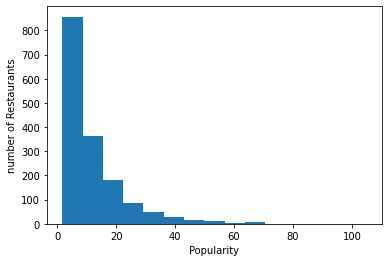

In [184]:
plt.hist(popData.Popularity, bins=15)
plt.xlabel("Popularity")
plt.ylabel("number of Restaurants")
plt.show()

## Insight 3: Optimizing Delivery Areas

---

Because FoodieX is delivering food throughout the entire town, it would be a waste of time and money for a driver to deliver food from a restaurant that is on the opposite side of town from their current location. Thus, it would be best to split the town into specific areas, where a driver in a specific area can deliver food from a restaurant in their current area. This would increase productivity, as drivers are now able to pick up the food more quickly.

While this can be done by hand, it would be nice to optimize the delivery areas so that delivery times are most efficient.

To find these areas, the Latitude and Longitude of each restaurant are put into a new dataframe.

In [185]:
location = data[["Latitude", "Longitude"]]

Next, we form clusters based on the restuarants relative distance from each other. Depending on the number of drivers on a given day, the number of separate areas can be increased or decreased.

In [186]:
from sklearn.cluster import KMeans

nAreas = 10
kmeans = KMeans(nAreas).fit(location)

Finally, we can plot the clusters to show the optimal delivery areas. We can also plot the center of each cluster, showing where a driver could wait if they are waiting for a order to occur in a certain delivery area.

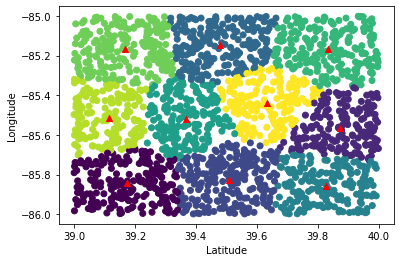

In [187]:
plt.scatter(data["Latitude"], data["Longitude"], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='red', marker='^')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

## Insight 4: Recommending Similar Cuisines

---

There is a massive vareity of food in the world, and it is a daunting task to categorize every single type of food. However, it is even more daunting to look at all 94 different cuisines FoodieX can deliver and attempt to differentiate between them all. It would be nice if there was a way to recommend different cuisines based on their similarity to an already liked cuisine.

To find connections between different cuisines, restaurants that serve more than one cuisine will be analyzed. My reasoning is that a restaurant that serves multiple cuisines will most likely serve cuisines that complement each other or have strong similarities.

To show the connections between two cuisines, the sum of restaurants that serve both cuisines will be found. A new dataframe is created with each cuisine on both the x and y axes. Then, the entry shared by two cuisines will be filled in as the square root of the sum of restaurants that share both cuisines. The square root is taken so that massive connections do not overpower the data.



In [188]:
diversity = pd.DataFrame(index=cuisineColumns, columns=cuisineColumns)
diversity = diversity.fillna(0)

for n, i in enumerate(cuisineColumns):
    for j in cuisineColumns[n:]:
        if i == j:
            continue
        diversity.loc[[j], [i]] = sqrt((data[i] & data[j]).sum())

diversity

,is_Afghan,is_American,is_Andhra,is_Arabian,is_Asian,is_Assamese,is_Awadhi,is_BBQ,is_Bakery,is_Bangladeshi,is_Bar Food,is_Belgian,is_Bengali,is_Beverages,is_Bihari,is_Biryani,is_Bohri,is_Brazilian,is_Bubble Tea,is_Burger,is_Burmese,is_Cafe,is_Cantonese,is_Charcoal Chicken,is_Chettinad,is_Chinese,is_Coffee,is_Continental,is_Desserts,is_European,is_Fast Food,is_Finger Food,is_French,is_Frozen Yogurt,is_German,is_Goan,is_Gujarati,is_Healthy Food,is_Hyderabadi,is_Ice Cream,...,is_Lebanese,is_Lucknowi,is_Maharashtrian,is_Malaysian,is_Mangalorean,is_Mediterranean,is_Mexican,is_Mishti,is_Mithai,is_Modern Indian,is_Momos,is_Mughlai,is_Naga,is_North Eastern,is_North Indian,is_Odia,is_Paan,is_Parsi,is_Pizza,is_Poké,is_Portuguese,is_Rajasthani,is_Raw Meats,is_Roast Chicken,is_Rolls,is_Salad,is_Sandwich,is_Seafood,is_South Indian,is_Spanish,is_Sri Lankan,is_Steak,is_Street Food,is_Sushi,is_Tamil,is_Tea,is_Thai,is_Tibetan,is_Vietnamese,is_Wraps
is_Afghan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
is_American,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
is_Andhra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
is_Arabian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
is_Asian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
is_Tea,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.236068,0.0,0.000000,0.0,0.0,1.0,0.000000,1.0,2.0,0.0,0.0,0.0,1.000000,1.0,0.00000,1.732051,0.0,2.645751,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,1.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0
is_Thai,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,5.477226,0.0,2.44949,0.000000,1.0,1.000000,0.0,0.0,0.0,0.0,1

Note that only half of the chart is filled out, as the other half is redundant, and the diagonal does not give any new insights. Now, we can plot a heatmap of the connections and visually see which connections are strongest.

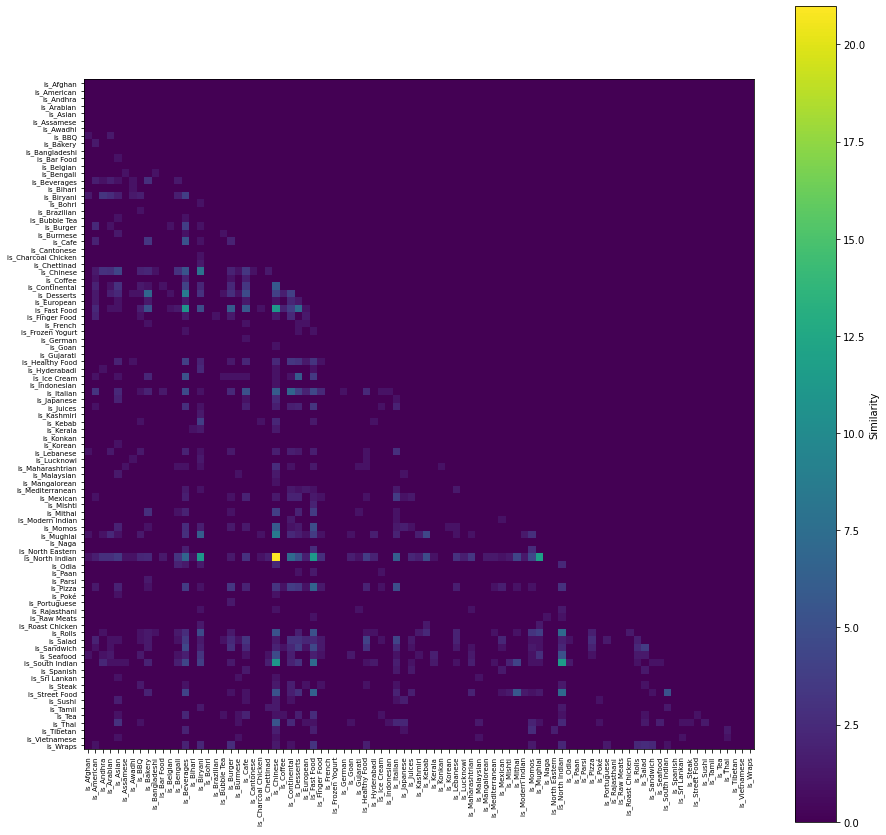

In [194]:
plt.figure(figsize=(15,15))
plt.imshow(diversity)
plt.xticks(ticks=range(len(cuisineColumns)), labels=cuisineColumns, rotation=90, fontsize=7)
plt.yticks(ticks=range(len(cuisineColumns)), labels=cuisineColumns, fontsize=7)
plt.colorbar(label="Similarity")
plt.show()

For example, the plot shows that many restuarants serve both North Indian food and Chinese food, so a user who reguarly orders Chinese food could be recommended to try North Indian food.

## Conclusion

---

Using the FoodieX dataset, I was able to provide 4 unique and useful insights that can be used to better improve and optimize the FoodieX service. I provided predicted rating of new and upcoming restaurants, I determined which restaurants were trending most with users, I designed a model to give ideal locations for delivery drivers to wait pick up meals from, and I developed a method of showing how closely related two cuisines are to each other.